In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [ ]:
import os

import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline


# from keras.layers import Dense, Dropout, Flatten
# from keras.layers import Conv2D, MaxPooling2D
# from keras import backend as K
# from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import ImageDataGenerator
# import sklearn.metrics as metrics


from keras.utils import plot_model

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [29]:
# Train data
EOSINOPHIL_dir = r'data/.dataset2-master/images/TRAIN/EOSINOPHIL'
LYMPHOCYTE_dir = r'data/.dataset2-master/images/TRAIN/LYMPHOCYTE'
MONOCYTE_dir = r'data/.dataset2-master/images/TRAIN/MONOCYTE'
NEUTROPHIL_dir = r'data/.dataset2-master/images/TRAIN/NEUTROPHIL'

filepaths = []
labels = []
dir_list = [EOSINOPHIL_dir, LYMPHOCYTE_dir, MONOCYTE_dir, NEUTROPHIL_dir]
class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

for i, dir in enumerate(dir_list):
    flist = os.listdir(dir)
    for f in flist:
        fpath = os.path.join(dir, f)
        filepaths.append(fpath)
        labels.append(class_labels[i])

bloodCellTrain_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
print(bloodCellTrain_df["labels"].value_counts())
bloodCellTrain_df

labels
NEUTROPHIL    2499
EOSINOPHIL    2497
LYMPHOCYTE    2483
MONOCYTE      2478
Name: count, dtype: int64


,filepaths,labels
0,data/.dataset2-master/images/TRAIN/EOSINOPHIL\...,EOSINOPHIL
1,data/.dataset2-master/images/TRAIN/EOSINOPHIL\...,EOSINOPHIL
2,data/.dataset2-master/images/TRAIN/EOSINOPHIL\...,EOSINOPHIL
3,data/.dataset2-master/images/TRAIN/EOSINOPHIL\...,EOSINOPHIL
4,data/.dataset2-master/images/TRAIN/EOSINOPHIL\...,EOSINOPHIL
...,...,...
9952,data/.dataset2-master/images/TRAIN/NEUTROPHIL\...,NEUTROPHIL
9953,data/.dataset2-master/images/TRAIN/NEUTROPHIL\...,NEUTROPHIL
9954,data/.dataset2-master/images/TRAIN/NEUTROPHIL\...,NEUTROPHIL
9955,data/.dataset2-master/images/TRAIN/NEUTROPHIL\...,NEUTROPHIL


In [30]:


# Test data
EOSINOPHIL_dir_test = r'data/.dataset2-master/images/TEST/EOSINOPHIL'
LYMPHOCYTE_dir_test = r'data/.dataset2-master/images/TEST/LYMPHOCYTE'
MONOCYTE_dir_test = r'data/.dataset2-master/images/TEST/MONOCYTE'
NEUTROPHIL_dir_test = r'data/.dataset2-master/images/TEST/NEUTROPHIL'

filepaths_test = []
labels_test = []
dir_list_test = [EOSINOPHIL_dir_test, LYMPHOCYTE_dir_test, MONOCYTE_dir_test, NEUTROPHIL_dir_test]
class_labels_test = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

for i, dir in enumerate(dir_list_test):
    flist = os.listdir(dir)
    for f in flist:
        fpath = os.path.join(dir, f)
        filepaths_test.append(fpath)
        labels_test.append(class_labels_test[i])

bloodCellTest_df = pd.DataFrame({'filepaths': filepaths_test, 'labels': labels_test})
print(bloodCellTest_df["labels"].value_counts())
bloodCellTest_df

labels
NEUTROPHIL    624
EOSINOPHIL    623
LYMPHOCYTE    620
MONOCYTE      620
Name: count, dtype: int64


,filepaths,labels
0,data/.dataset2-master/images/TEST/EOSINOPHIL\_...,EOSINOPHIL
1,data/.dataset2-master/images/TEST/EOSINOPHIL\_...,EOSINOPHIL
2,data/.dataset2-master/images/TEST/EOSINOPHIL\_...,EOSINOPHIL
3,data/.dataset2-master/images/TEST/EOSINOPHIL\_...,EOSINOPHIL
4,data/.dataset2-master/images/TEST/EOSINOPHIL\_...,EOSINOPHIL
...,...,...
2482,data/.dataset2-master/images/TEST/NEUTROPHIL\_...,NEUTROPHIL
2483,data/.dataset2-master/images/TEST/NEUTROPHIL\_...,NEUTROPHIL
2484,data/.dataset2-master/images/TEST/NEUTROPHIL\_...,NEUTROPHIL
2485,data/.dataset2-master/images/TEST/NEUTROPHIL\_...,NEUTROPHIL


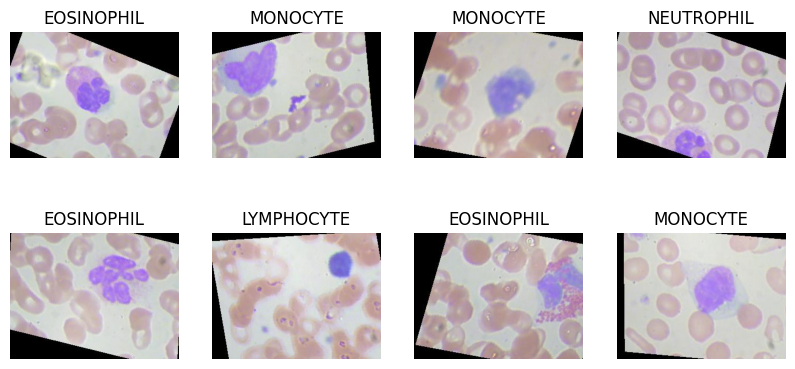

In [83]:
# visualize a few random images of the trainign data df
import matplotlib.pyplot as plt
import skimage.io

plt.figure(figsize=(10, 10))
list_random_images = bloodCellTrain_df.sample(n=8, random_state=123)
for i in range(8):
    plt.subplot(4, 4, i + 1)
    random_image_path = list_random_images.iloc[i]['filepaths']
    random_image = skimage.io.imread(random_image_path)
    random_image_label = list_random_images.iloc[i]['labels']
    plt.imshow(random_image)
    plt.title(random_image_label)
    plt.axis('off')
plt.show()

In [38]:
train_test_ratio = bloodCellTest_df.shape[0] / bloodCellTrain_df.shape[0]
print(f"Train Test Ratio (number of test data / number of train data): {train_test_ratio:.2f}")

Train Test Ratio (number of test data / number of train data): 0.25


In [56]:
train_images, val_images = train_test_split(bloodCellTrain_df, test_size=0.25, random_state=42)
# train_set, val_set = train_test_split(bloodCell_df, test_size=0.2, random_state=42)
train_images = bloodCellTrain_df
test_images = bloodCellTest_df

In [59]:
# print(train_set.shape)
print(test_images.shape)
print(val_images.shape)
print(train_images.shape)

(2487, 2)
(2490, 2)
(9957, 2)


In [60]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_images,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=8,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=8,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_images,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=8,
                                    shuffle=False
                                   )

Found 9957 validated image filenames belonging to 4 classes.
Found 2487 validated image filenames belonging to 4 classes.
Found 2490 validated image filenames belonging to 4 classes.


In [61]:
classes=list(train.class_indices.keys())
print (classes)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


### Build the model

In [9]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 73, 73, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 73, 73, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 6, 512)      │         2,04

 Total params: 15,611,524 (59.55 MB)

 Trainable params: 15,605,124 (59.53 MB)

 Non-trainable params: 6,400 (25.00 KB)

train vith train and val

In [ ]:
if not os.path.exists('data/CNN_10epochs.keras'):
    history = model.fit(train, epochs=10, validation_data=val, verbose=1)
    model.save('data/CNN_10epochs.keras')
    np.save('data/history.npy', history.history)
else:
    model = keras.models.load_model('data/CNN_10epochs.keras')
    history = np.load('data/history.npy', allow_pickle=True).item()

evaluate the model with test images

In [ ]:
loss, accuracy = model.evaluate(test, verbose=1)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

374/374 ━━━━━━━━━━━━━━━━━━━━ 207s 553ms/step - accuracy: 0.9832 - loss: 0.0494


[0.044006433337926865, 0.9836010932922363]

In [89]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

311/311 ━━━━━━━━━━━━━━━━━━━━ 158s 509ms/step
[0 3 0 ... 0 3 3]


In [90]:
print(pred2)
print(pred)
print(labels)

['EOSINOPHIL', 'NEUTROPHIL', 'EOSINOPHIL', 'NEUTROPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'NEUTROPHIL', 'NEUTROPHIL', 'EOSINOPHIL', 'NEUTROPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'NEUTROPHIL', 'NEUTROPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'NEUTROPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'NEUTROPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'NEUTROPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'NEUTROPHIL', 'NEUTROPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'LYMPHOCYTE', 'NEUTROPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'NEUTROPHIL', 'EOSINOPHIL', 'NEUTROPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'MONOCYTE', 'EOSINOPHIL', 'NEUTROPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'NEUTROPHIL', 'EOSINOPHIL', 'NEUTROPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'NEUTROPHIL', 'EOSINOPHIL', 'NEUTRO

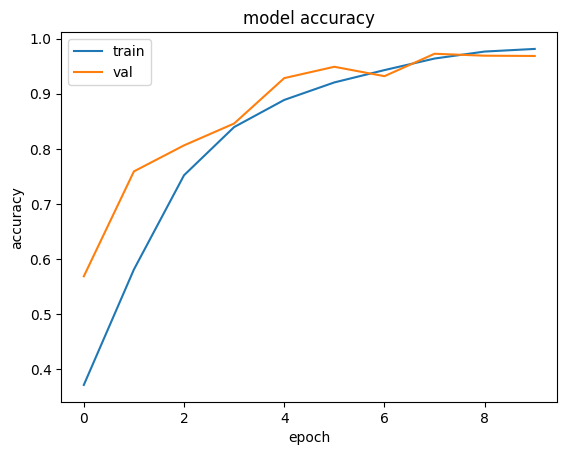

In [84]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

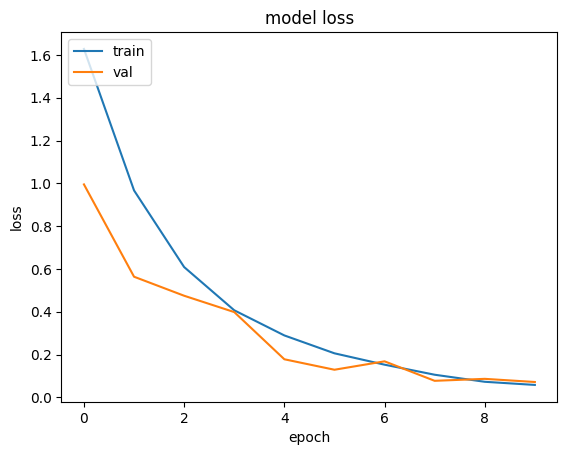

In [87]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

  EOSINOPHIL       0.97      0.97      0.97       781
  LYMPHOCYTE       0.99      1.00      0.99       764
    MONOCYTE       1.00      1.00      1.00       729
  NEUTROPHIL       0.97      0.97      0.97       714

    accuracy                           0.98      2988
   macro avg       0.98      0.98      0.98      2988
weighted avg       0.98      0.98      0.98      2988

Accuracy of the Model: 98.4%


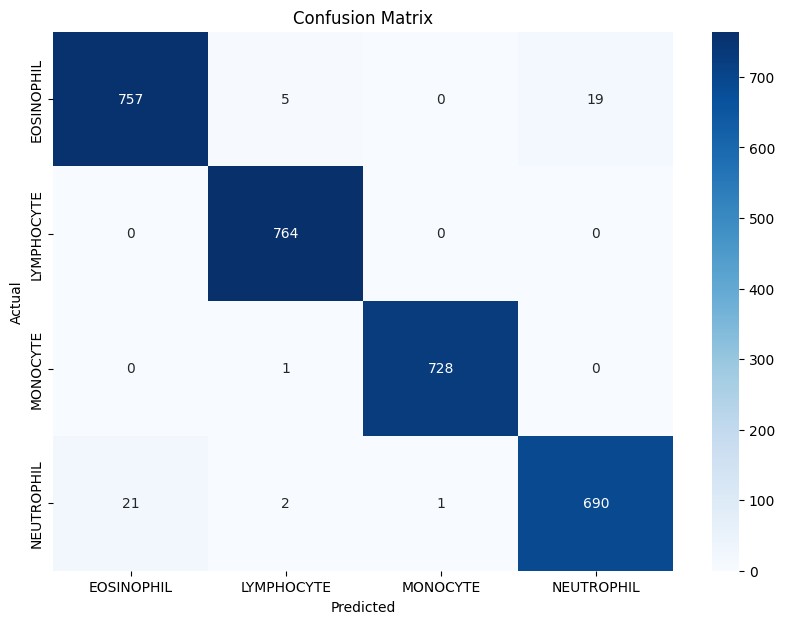

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

plot sample predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


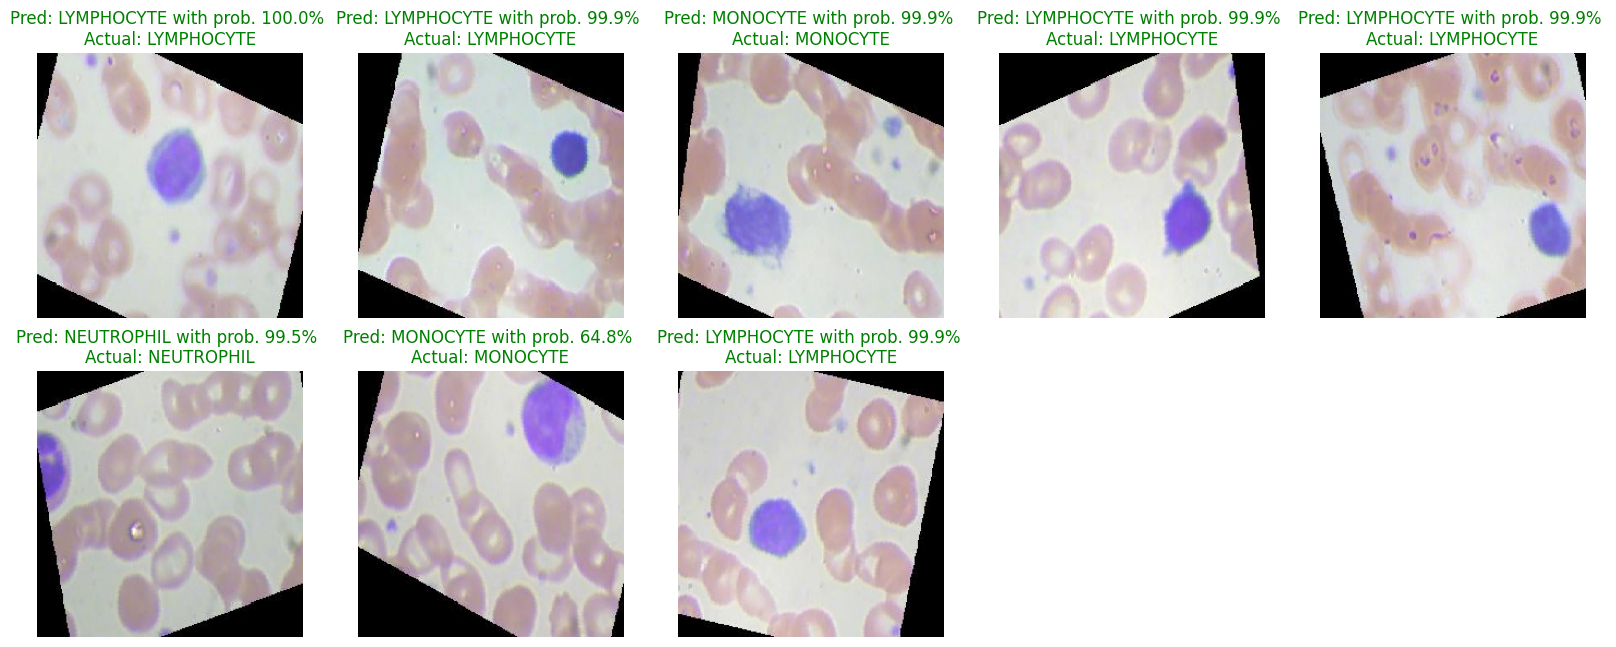

In [19]:
# plot two sample blood images and the predictions and actual labels
def show_images_with_predictions(image_gen, model):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels = next(image_gen)  # get a sample batch from the generator
    predictions = model.predict(images)  # get predictions from the model
    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 25:
        r = length
    else:
        r = 25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = (images[i] + 1) / 2  # scale images between 0 and 1
        plt.imshow(image)
        actual_index = np.argmax(labels[i])
        predicted_index = np.argmax(predictions[i])
        prediction_probability = predictions[i][predicted_index]
        actual_class = classes[actual_index]
        predicted_class = classes[predicted_index]
        title_color = "green" if actual_class == predicted_class else "red"
        plt.title(f"Pred: {predicted_class} with prob. {int(prediction_probability*1000)/10}% \nActual: {actual_class}", color=title_color, fontsize=12)
        plt.axis('off')
    plt.show()

# Call the function with the test generator and trained model
show_images_with_predictions(test, model)